# Preparação e tratamento dos dados - Parte 2

## Objetivo

Este código tem como objetivo tratar a base "ans.csv" desenvolvida na parte 1

As etapas abordadas no tratamento de dados desenvolvido neste código são as seguintes:

1. Filtragem por tipo de contratação, porte e modalidade de operadora
1. Agrupamento das informações de receita, despesa e total de beneficiarios
1. Identificação e tratamento de dados outliers de receita e despesa
1. Criação da base para ser utilizada na etapa de forecast

## Este código aborda as informações do seguinte segmento:

### Adesão - Modalidade Cooperativa Médica

In [1]:
#Bibliotecas
import os
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from pandas.core.reshape.merge import merge
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.6f}'.format

In [2]:
#Funções auxiliares

def sum_billion(x):    
    return round(((x.sum())/1000000000.0),2)

def sum_million(x):    
    return round(((x.sum())/1000000.0),2)

def sum_thousand(x):    
    return round(((x.sum())/1000.0),2)

def media_agregada(x):    
    return round(((x.sum())/12.0),0)

### Seleção do Período para o tratamento dos dados

In [3]:
#Seleção do Periodo de análise

inicio = '2017-09-01'

fim = '2022-03-01'

Periodo = [inicio, fim]

### Parametros para filtragem dos dados

In [4]:
#Parametros para filtragem dos dados

contratacao_list = ['Adesao', 'Empresarial', 'Individual']

modalidade_list = ['Medicina de Grupo', 'Cooperativa Médica', 'Autogestão', 'Filantropia', 'Seguradora']

tipo_contratacao = 'Empresarial'

tipo_modalidade = 'Filantropia'

## Leitura dos dados

Carregamento e leitura da base desenvolvida na parte 1 do código

In [5]:
path = f'D:/TCC/tcc-main/codigos/preparacao_dados/analise_agrupadas' + '\\' + 'ans.csv'

ans = pd.read_csv(path, sep=';', decimal= ',', encoding='mbcs')  #Leitura da base

#modificando os tipos de dados

ans['ano'] = ans['ano'].astype('str')

ans['cd_ops'] = ans['cd_ops'].astype('str')

ans['lg_cancelada'] = ans['lg_cancelada'].astype('str')

ans['lg_nova_ops'] = ans['lg_nova_ops'].astype('str')

ans['ano'] = pd.PeriodIndex(ans['ano'], freq="Y")

ans['trimestre'] = pd.PeriodIndex(ans['trimestre'], freq="Q")

#Filtrando os dados até 2021
ans = ans[(ans.ano > '2017') & (ans.ano < '2022')]

ans = ans.replace(' NaN', np.NaN)

ans = ans.dropna()

#Filtra somente as operadas com flag ativas
ans_filt = ans[(ans['lg_cancelada']!='1.0') & (ans['benef']!=np.nan)].reset_index(drop=True)

ans_filt.head()

,ano,cd_ops,razao_social,modalidade,port_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,receita,despesa,benef,lg_cancelada,lg_nova_ops
0,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/03/2018,2018Q1,791860.200000,0.000000,722.000000,0.0,0.0
1,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/06/2018,2018Q2,769499.340000,0.000000,731.000000,0.0,0.0
2,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/09/2018,2018Q3,846654.020000,0.000000,774.000000,0.0,0.0
3,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/12/2018,2018Q4,903017.550000,0.000000,787.000000,0.0,0.0
4,2019,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/06/2019,2019Q2,1801080.840000,0.000000,775.000000,0.0,0.0


In [6]:
#Filtra o segmento abordado neste código
ans_filt_cont_mod = ans_filt[ (ans_filt['contratacao'] == tipo_contratacao) & 
                              (ans_filt['modalidade'] == tipo_modalidade) ].reset_index(drop=True)

ans_filt_cont_mod = ans_filt_cont_mod[['ano', 'cd_ops', 'razao_social', 'modalidade', 'port_ops', 'vigencia', 'contratacao', 'financiamento', 'trimestre', 'receita', 'despesa', 'benef']]

ans_filt_cont_mod.head()


,ano,cd_ops,razao_social,modalidade,port_ops,vigencia,contratacao,financiamento,trimestre,receita,despesa,benef
0,2018,306045,SANTA CASA DE MISERICÓRDIA DE TUPÃ,Filantropia,Pequeno,P,Empresarial,Pre-estabelecido,2018Q1,1522726.530000,813503.080000,1665.000000
1,2018,306045,SANTA CASA DE MISERICÓRDIA DE TUPÃ,Filantropia,Pequeno,P,Empresarial,Pre-estabelecido,2018Q2,1570298.990000,1053459.600000,1644.000000
2,2018,306045,SANTA CASA DE MISERICÓRDIA DE TUPÃ,Filantropia,Pequeno,P,Empresarial,Pre-estabelecido,2018Q3,1607607.830000,1052819.670000,1632.000000
3,2018,306045,SANTA CASA DE MISERICÓRDIA DE TUPÃ,Filantropia,Pequeno,P,Empresarial,Pre-estabelecido,2018Q4,1633836.260000,1028214.440000,1616.000000
4,2019,306045,SANTA CASA DE MISERICÓRDIA DE TUPÃ,Filantropia,Pequeno,P,Empresarial,Pre-estabelecido,2019Q1,1666332.120000,1017051.020000,1593.000000


In [7]:
ans_filt_cont_mod[['ano','cd_ops','trimestre','receita','despesa','benef','modalidade','port_ops','contratacao']].to_csv('emp_g_filan.csv', sep=';', index=False, encoding='mbcs', decimal=',')

ans_filt_cont_mod.groupby(['ano','cd_ops','razao_social','trimestre']).agg({'receita':lambda x: sum_million(x),'despesa':lambda x: sum_million(x)}).head()

receita   despesa
ano  cd_ops razao_social                                           trimestre                    
2018 306045 SANTA CASA DE MISERICÓRDIA DE TUPÃ                     2018Q1     1.520000  0.810000
                                                                   2018Q2     1.570000  1.050000
                                                                   2018Q3     1.610000  1.050000
                                                                   2018Q4     1.630000  1.030000
     314218 ASSOCIAÇÃO DE BENEFICÊNCIA E FILANTROPIA SÃO CRISTOVÃO 2018Q1    27.980000 18.710000

### Agregação dos valores de receita e despesa e quantidade de beneficiarios

In [8]:
ans_filt_cont_mod_agrup = ans_filt_cont_mod.groupby(['ano','trimestre'], as_index=False).agg({ 'receita':lambda x: sum_million(x),
                                                                                               'despesa':lambda x: sum_million(x),
                                                                                               'benef': 'sum',
                                                                                               'cd_ops':lambda x: x.nunique()})

ans_filt_cont_mod_agrup['pct_despesa'] = ans_filt_cont_mod_agrup.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_filt_cont_mod_agrup.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_filt_cont_mod_agrup = ans_filt_cont_mod_agrup[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_filt_cont_mod_agrup = ans_filt_cont_mod_agrup[(ans_filt_cont_mod_agrup.trimestre > '2017Q4') & (ans_filt_cont_mod_agrup.trimestre < '2022Q1')]

ans_filt_cont_mod_agrup[['n_ops','benef']] = ans_filt_cont_mod_agrup[['n_ops','benef']].astype('int')

ans_filt_cont_mod_agrup.set_index('trimestre', inplace=True)

ans_filt_cont_mod_agrup

,receita,despesa,benef,n_ops,pct_despesa
trimestre,,,,,
2018Q1,211.490000,162.700000,437328,28,76.930000
2018Q2,218.220000,176.760000,444418,28,81.000000
2018Q3,226.660000,184.310000,449399,29,81.320000
2018Q4,230.060000,174.790000,442655,28,75.980000
2019Q1,230.090000,177.160000,446972,28,77.000000
2019Q2,242.220000,199.600000,459830,30,82.400000
2019Q3,251.150000,198.480000,465418,30,79.030000
2019Q4,261.480000,207.740000,470917,30,79.450000
2020Q1,268.950000,183.820000,474707,30,68.350000


## As próximas etapas tratam da identificação de outliers e tratamentes desses dados com problemas

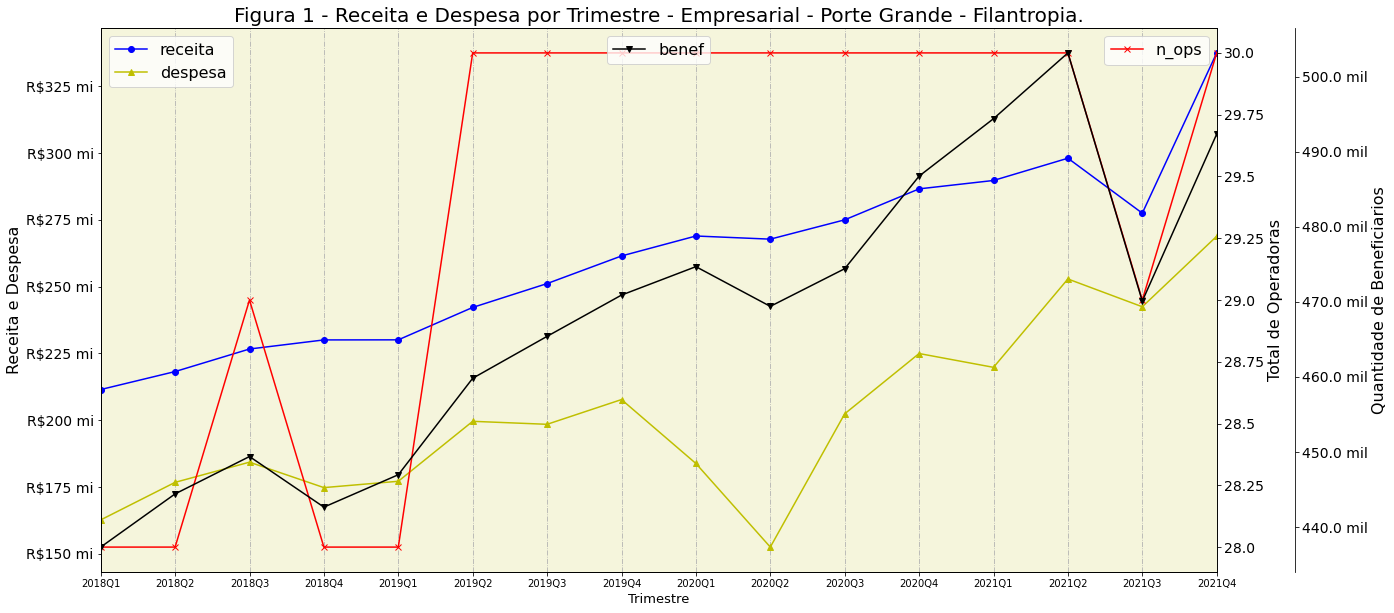

In [9]:
df_plot = ans_filt_cont_mod_agrup.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 1 - Receita e Despesa por Trimestre - Empresarial - Porte Grande - Filantropia.',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} mi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(yticks, fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['benef'], figsize=(20,10), style=['kv-'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.1f} mil'.format(x/1e3) for x in yticks], fontsize = 14)
ax3.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax3.legend(loc = 'upper center', fontsize = 16)

plt.savefig('emp_filan_01.png',
 bbox_inches="tight",
 pad_inches=1,
 facecolor='w')

plt.show()

del df_plot

In [10]:
#Cria o rankin das operadoras com maior receita e despesa
ans_filt_cont_mod_agrup_ops = ans_filt_cont_mod.groupby(['ano','cd_ops','trimestre'], as_index=False).agg({'receita':lambda x: sum_million(x),
                                                                                                           'despesa':lambda x: sum_million(x),
                                                                                                           'benef': 'sum'}).reset_index(drop=True)

ans_filt_cont_mod_agrup_ops = ans_filt_cont_mod_agrup_ops.sort_values(['benef'],ascending = False).groupby('trimestre').head(100).reset_index()

#ans_filt_ind_seg_agrup_ops.sort_values(by=['ano','benef'], ascending=[True,False], inplace=True)

ans_filt_cont_mod_agrup_ops.head()

,index,ano,cd_ops,trimestre,receita,despesa,benef
0,414,2021,339954,2021Q4,85.680000,75.280000,126811.000000
1,413,2021,339954,2021Q3,82.180000,76.070000,123792.000000
2,412,2021,339954,2021Q2,78.870000,73.120000,121335.000000
3,411,2021,339954,2021Q1,76.370000,67.470000,120071.000000
4,294,2020,339954,2020Q4,75.480000,66.990000,115854.000000


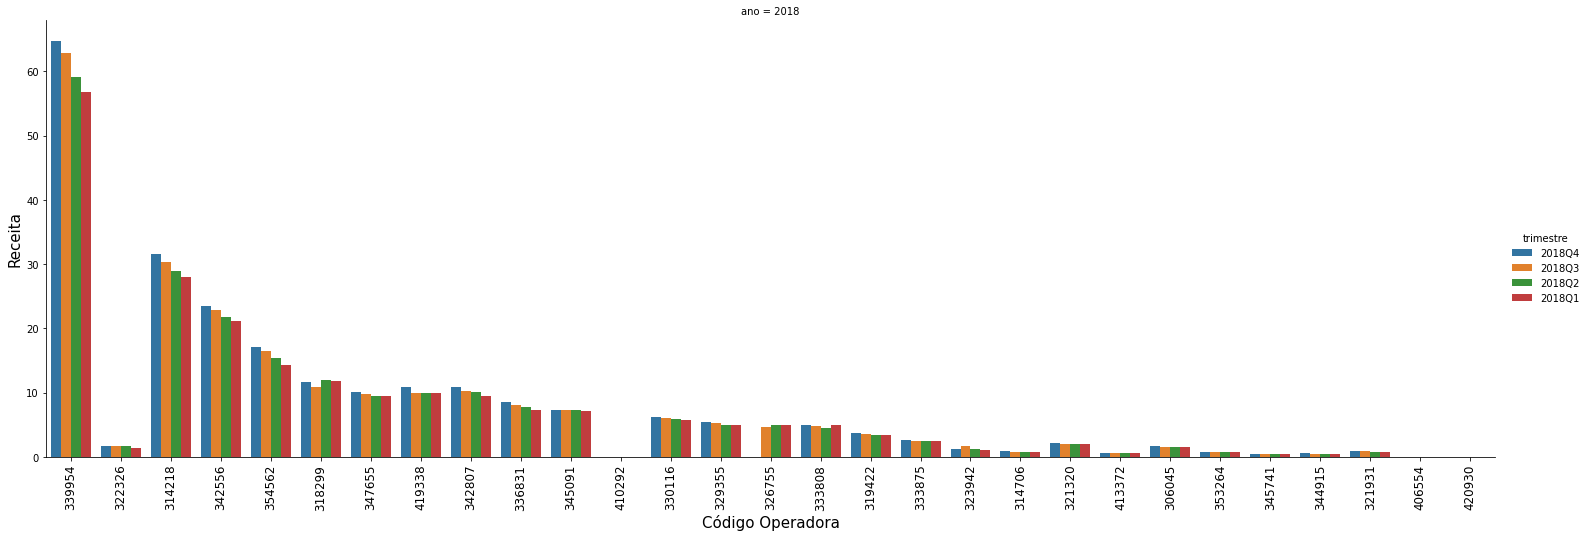

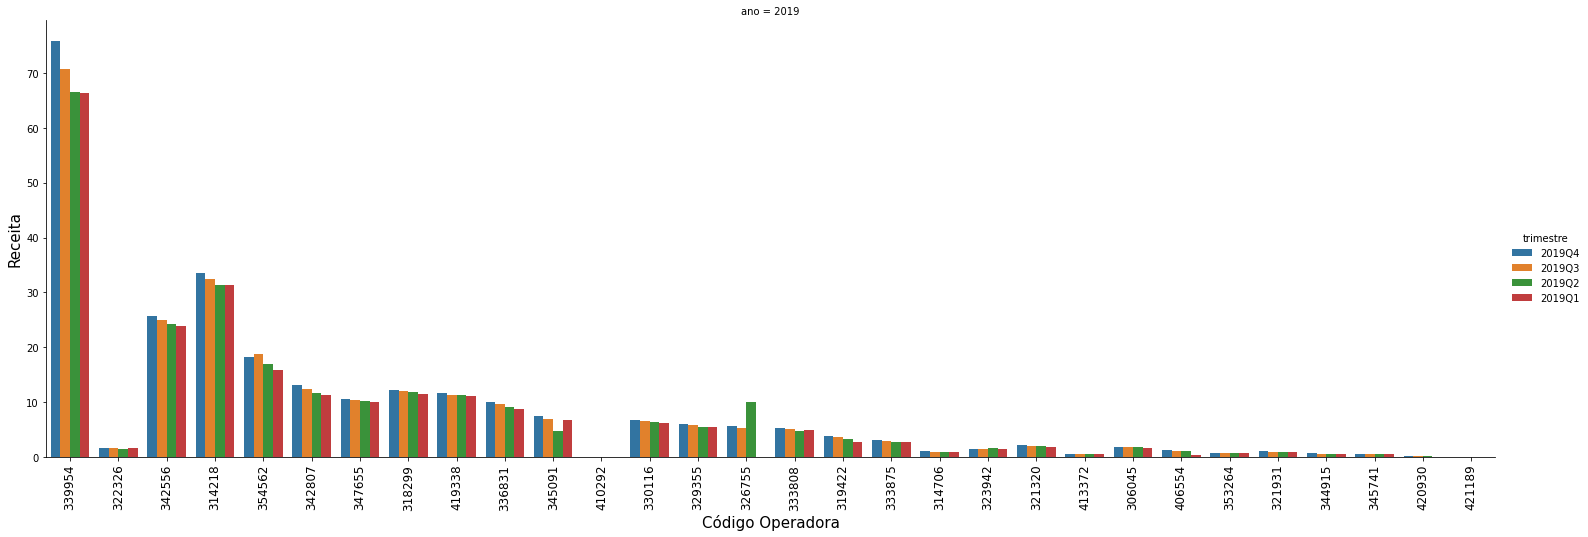

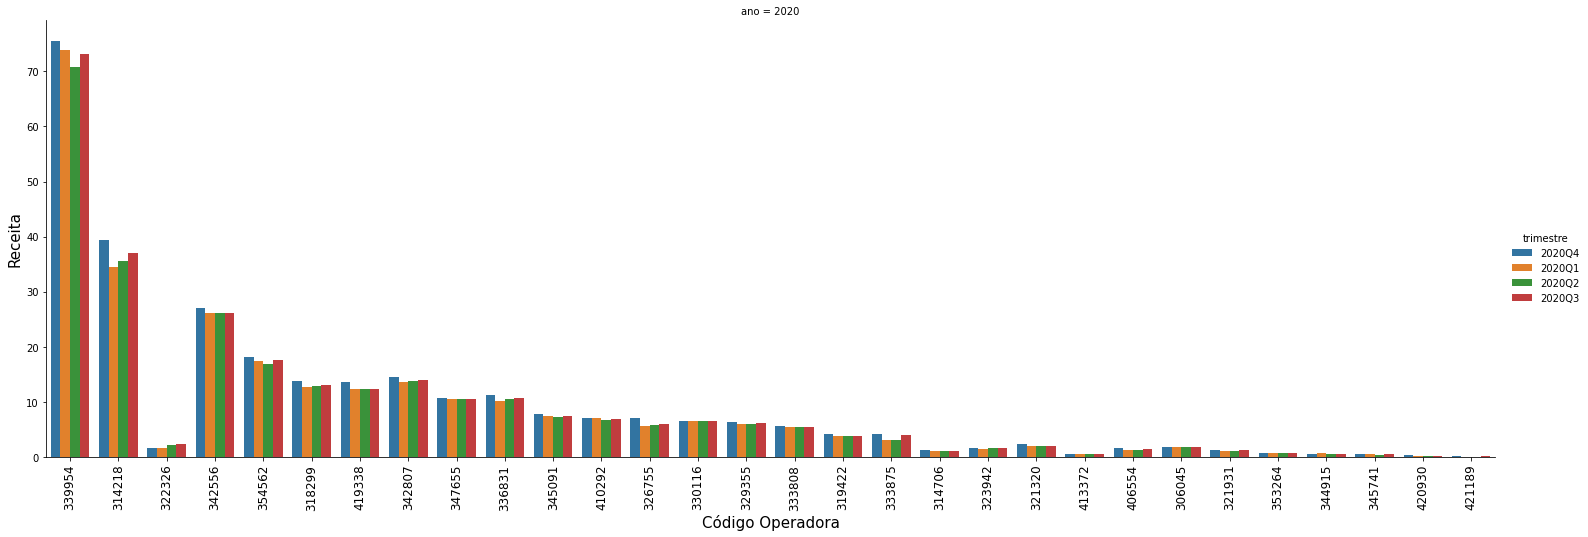

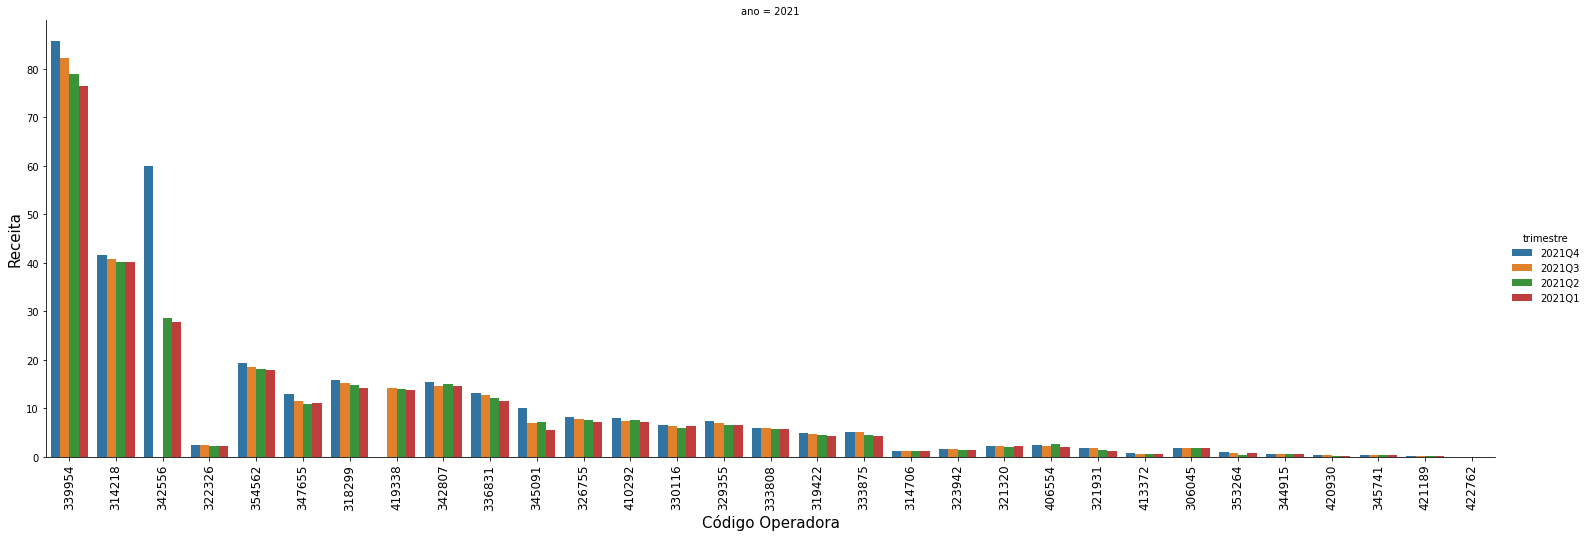

In [11]:
df_plot = ans_filt_cont_mod_agrup_ops.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)
ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)
ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)
ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

del df_plot

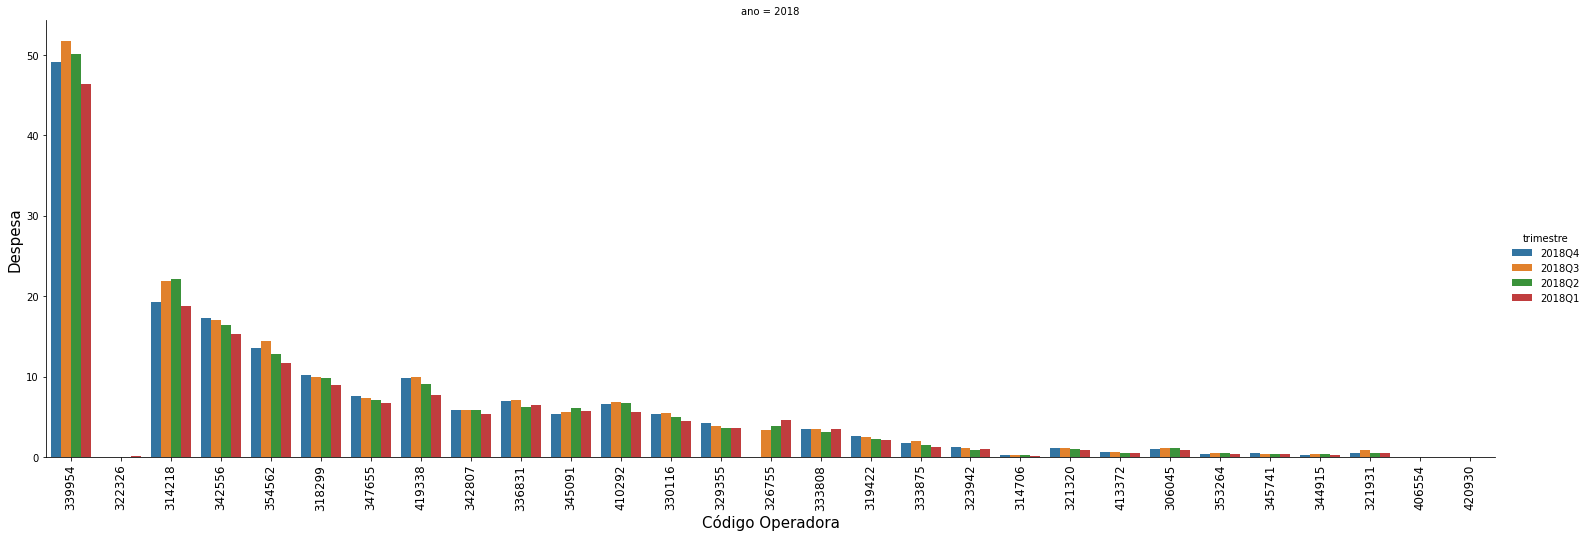

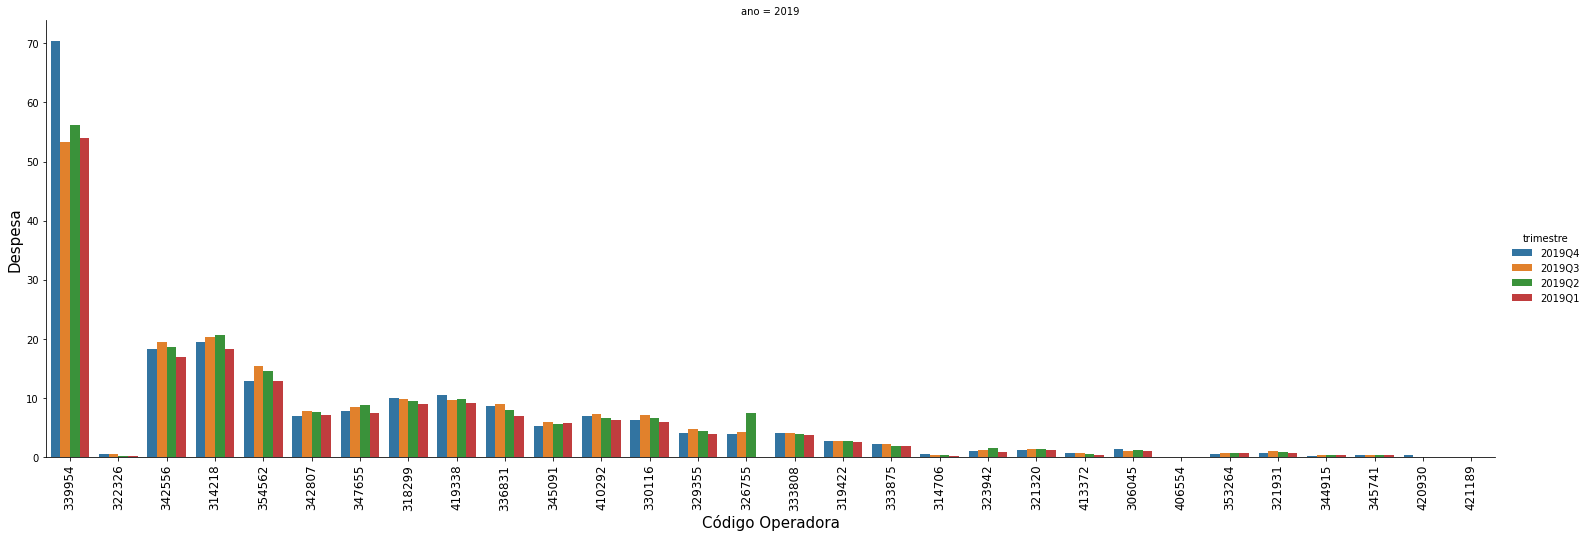

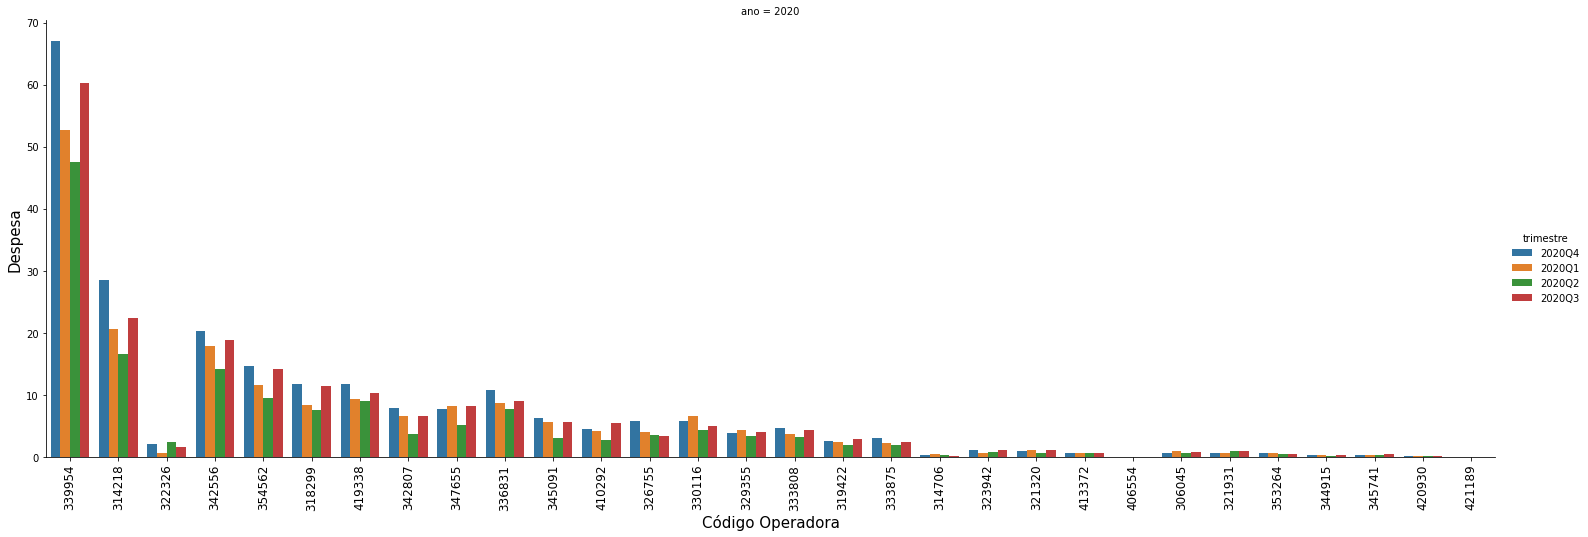

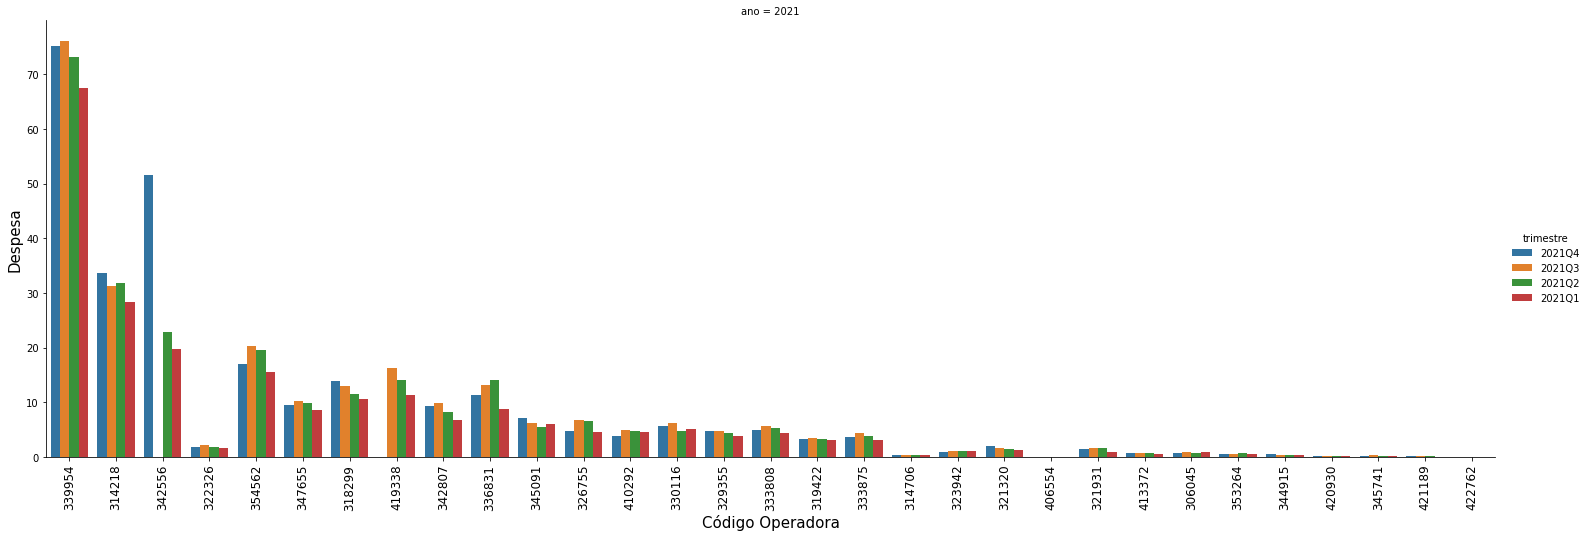

In [12]:
df_plot = ans_filt_cont_mod_agrup_ops.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)
ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)
ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)
ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

### Limpeza e Tratamento de Dados dos outliers

Nos gráficos acima é possivel observar que as curvas de receita e despesas possuem pontos outliers, provavelmente ocasionados pelo por erros de lançamentos das demonstrações contabeis.

E além disso, nos gráficos de barras por operadoras, mostra que muitas operadoras não possuem lançamentos em todos os trimestres do ano. Essas ausencias de lançamentos também ajudam no aparecimento de pontos outliers na evolução trimestral de receita e despesa.

Os códigos das células abaixo, tem com objetivo corrigir essas falhas de lançamentos de demontrações contabeis trimestrais. E na última parte do tratamento, possui o objetivo de corrigir alguns desvios do da curva de receita e depesa trimestral.

#### 1ª Etapa - Preenchendo lançamentos faltantes de algumas operadoras

In [13]:
#Agrupamento da receita e despesa de cada operadora por trimestre
ans_alterada1 = ans_filt_cont_mod.groupby(['ano','cd_ops','trimestre'], as_index=False).agg({'receita':'sum',
                                                                                             'despesa':'sum'})

ans_alterada1 = ans_alterada1[(ans_alterada1['ano']>'2017') & (ans_alterada1['ano']<'2022')] #Filtra anos de 2018 até 2021

ans_alterada1 = ans_alterada1.drop(ans_alterada1[(ans_alterada1.receita != 0) & (ans_alterada1.despesa == 0)].index)

ans_alterada1 = ans_alterada1.drop(ans_alterada1[(ans_alterada1.receita == 0) & (ans_alterada1.despesa != 0)].index)

ans_alterada1 = ans_alterada1.drop(ans_alterada1[(ans_alterada1.receita == 0) & (ans_alterada1.despesa == 0)].index)

display(ans_alterada1.head())

,ano,cd_ops,trimestre,receita,despesa
0,2018,306045,2018Q1,1522726.530000,813503.080000
1,2018,306045,2018Q2,1570298.990000,1053459.600000
2,2018,306045,2018Q3,1607607.830000,1052819.670000
3,2018,306045,2018Q4,1633836.260000,1028214.440000
4,2018,314218,2018Q1,27979406.300000,18711233.050000


In [14]:
#Identificação das operadora que não possuem os 4 lançamentos contabeis durante o ano, ou seja, existem algumas operadoras que possuem falhas na publicação des demonstrações de contabilidade
ans_alterada2 = ans_alterada1.groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))

display(ans_alterada2.head())

ans_alterada2.n_trimestre.unique()

,ano,cd_ops,n_trimestre
0,2018,306045,4
1,2018,314218,4
2,2018,314706,4
3,2018,318299,4
4,2018,319422,4


array([4, 3, 1], dtype=int64)

In [15]:
#Operadoras com lançamento contabeis em todos os trimestres do período selecionado para o estudo
ans_alterada_complete = ans_alterada2[ans_alterada2['n_trimestre']==4].reset_index(drop=True)
ans_alterada_complete = ans_alterada_complete[['ano','cd_ops']]

display(ans_alterada_complete.info())

display(ans_alterada_complete.head())

#ans_alterada_complete[ans_alterada_complete['cd_ops']=='393321']

complete_ops_list = ans_alterada_complete['cd_ops'].to_numpy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype        
---  ------  --------------  -----        
 0   ano     107 non-null    period[A-DEC]
 1   cd_ops  107 non-null    object       
dtypes: object(1), period[A-DEC](1)
memory usage: 1.8+ KB


None

,ano,cd_ops
0,2018,306045
1,2018,314218
2,2018,314706
3,2018,318299
4,2018,319422


In [16]:
#Operadoras com lançamento contabeis faltando em algum(uns) trimestre(s) do período selecionado para o estudo
ans_alterada_imcomplete = ans_alterada2[ans_alterada2['n_trimestre']!=4].reset_index(drop=True)
ans_alterada_imcomplete = ans_alterada_imcomplete[['ano','cd_ops']]

display(ans_alterada_imcomplete.info())

display(ans_alterada_imcomplete.head())

imcomplete_ops_list = ans_alterada_imcomplete['cd_ops'].to_numpy()

#ans_alterada_imcomplete[ans_alterada_imcomplete['cd_ops']=='393321']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype        
---  ------  --------------  -----        
 0   ano     8 non-null      period[A-DEC]
 1   cd_ops  8 non-null      object       
dtypes: object(1), period[A-DEC](1)
memory usage: 256.0+ bytes


None

,ano,cd_ops
0,2018,326755
1,2018,410292
2,2018,420930
3,2019,326755
4,2019,421189


In [17]:
diff_list = np.setdiff1d(complete_ops_list,imcomplete_ops_list)

ans_alterada_complete = ans_alterada_complete[ans_alterada_complete["cd_ops"].isin(diff_list)]

#Dataframe somente com as operadoras com lançamentos completos
display(ans_alterada_complete.info())

display(ans_alterada_complete.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype        
---  ------  --------------  -----        
 0   ano     92 non-null     period[A-DEC]
 1   cd_ops  92 non-null     object       
dtypes: object(1), period[A-DEC](1)
memory usage: 2.2+ KB


None

,ano,cd_ops
0,2018,306045
1,2018,314218
2,2018,314706
3,2018,318299
4,2018,319422


In [18]:
#Filtra as operadoras com lançamentos completos
keys = list(ans_alterada_complete.columns.values)
i1 = ans_alterada1.set_index(keys).index
i2 = ans_alterada_complete.set_index(keys).index

ans_alterada3 =  ans_alterada1[i1.isin(i2)]

#Dataframe somente com dados das operadoras que possuem lançamento em todos os trimestre dos anos estudados neste trabalho
display(ans_alterada3.head())

#Verificação da filtragem
ans_alterada3_vef = ans_alterada3[(ans_alterada3['ano']>'2017') & (ans_alterada3['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
ans_alterada3_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
0,2018,306045,2018Q1,1522726.530000,813503.080000
1,2018,306045,2018Q2,1570298.990000,1053459.600000
2,2018,306045,2018Q3,1607607.830000,1052819.670000
3,2018,306045,2018Q4,1633836.260000,1028214.440000
4,2018,314218,2018Q1,27979406.300000,18711233.050000


array([4], dtype=int64)

In [19]:
#Cálculo do percentual de crescimento trimestral das receitas e despesas

#Este percentual será utilizado para corrigir os pontos outliers para as operadoras com lançamentos imcompletos

ans_alterada3['ref1'] = (   ans_alterada3['ano'].map(str) + 
                            ans_alterada3['cd_ops'].map(str))

ans_alterada3['ref2'] = (   ans_alterada3['ano'].map(str) + 
                            ans_alterada3['cd_ops'].map(str)+
                            ans_alterada3['trimestre'].map(str))

ans_alterada3[['receita_shifted','despesa_shifted']] = ans_alterada3[['ref1','ref2','receita','despesa']].groupby(['ref1'])[['receita','despesa']].shift()

ans_alterada3['pct_tri_receita'] = ((ans_alterada3['receita'] / ans_alterada3['receita_shifted'])) 
ans_alterada3['pct_tri_despesa'] = ((ans_alterada3['despesa'] / ans_alterada3['despesa_shifted'])) 
 
ans_alterada3 = ans_alterada3[['ano','cd_ops','trimestre','receita','receita_shifted','pct_tri_receita','despesa','despesa_shifted','pct_tri_despesa']].fillna(0)

ans_alterada3.head()

,ano,cd_ops,trimestre,receita,receita_shifted,pct_tri_receita,despesa,despesa_shifted,pct_tri_despesa
0,2018,306045,2018Q1,1522726.530000,0.000000,0.000000,813503.080000,0.000000,0.000000
1,2018,306045,2018Q2,1570298.990000,1522726.530000,1.031242,1053459.600000,813503.080000,1.294967
2,2018,306045,2018Q3,1607607.830000,1570298.990000,1.023759,1052819.670000,1053459.600000,0.999393
3,2018,306045,2018Q4,1633836.260000,1607607.830000,1.016315,1028214.440000,1052819.670000,0.976629
4,2018,314218,2018Q1,27979406.300000,0.000000,0.000000,18711233.050000,0.000000,0.000000


In [20]:
#Estatisticas referentes aos percentuais calculados na celula anterior

stats_ans_alterada = pd.DataFrame(ans_alterada3.groupby(['ano','trimestre'])[['pct_tri_receita','pct_tri_despesa']].describe(percentiles = [.25,.5,.75]))

stats_ans_alterada = stats_ans_alterada.reset_index(level=[0,1])

stats_ans_alterada.columns = ['_'.join(col) for col in stats_ans_alterada.columns.values]

stats_ans_alterada = stats_ans_alterada[['ano_','trimestre_','pct_tri_receita_25%', 'pct_tri_receita_75%', 'pct_tri_despesa_25%', 'pct_tri_despesa_75%']]

stats_ans_alterada.rename(columns = {'ano_':'ano',
                                     'trimestre_':'trimestre',
                                     'pct_tri_receita_25%':'pct_tri_receita_25',
                                     'pct_tri_receita_75%':'pct_tri_receita_75',
                                     'pct_tri_despesa_25%':'pct_tri_despesa_25',
                                     'pct_tri_despesa_75%':'pct_tri_despesa_75'}, inplace = True)

#Dataframe com os principais quartis dos crescimento percentuais calculados anteriormente
stats_ans_alterada

,ano,trimestre,pct_tri_receita_25,pct_tri_receita_75,pct_tri_despesa_25,pct_tri_despesa_75
0,2018,2018Q1,0.000000,0.000000,0.000000,0.000000
1,2018,2018Q2,1.005351,1.038146,1.029052,1.209011
2,2018,2018Q3,1.017508,1.052043,0.995631,1.125206
3,2018,2018Q4,1.028984,1.058535,0.873686,1.018973
4,2019,2019Q1,0.000000,0.000000,0.000000,0.000000
5,2019,2019Q2,0.977417,1.029923,1.057442,1.156438
6,2019,2019Q3,1.017829,1.070248,0.957455,1.078635
7,2019,2019Q4,1.011860,1.058334,0.895839,1.017651
8,2020,2020Q1,0.000000,0.000000,0.000000,0.000000
9,2020,2020Q2,0.995239,1.018725,0.654618,0.899216


In [21]:
#Identificando as operadoras que estão dentro do intervalo inter-quartil calculado acima
#Essa filtragem ajuda no cálculo do percentual do crescimento médio de receita e despesa

ans_alterada4 =  pd.merge(ans_alterada3, stats_ans_alterada, how = 'left', on = ['ano','trimestre'])

#Filtragem das operadoras
ans_alterada4 = ans_alterada4[( (ans_alterada4['pct_tri_receita'] >= ans_alterada4['pct_tri_receita_25']) & 
                                (ans_alterada4['pct_tri_receita'] <= ans_alterada4['pct_tri_receita_75'])) &
                                ((ans_alterada4['pct_tri_despesa'] >= ans_alterada4['pct_tri_despesa_25']) & 
                                (ans_alterada4['pct_tri_despesa'] <= ans_alterada4['pct_tri_despesa_75']))]

ans_alterada4.head()

,ano,cd_ops,trimestre,receita,receita_shifted,pct_tri_receita,despesa,despesa_shifted,pct_tri_despesa,pct_tri_receita_25,pct_tri_receita_75,pct_tri_despesa_25,pct_tri_despesa_75
0,2018,306045,2018Q1,1522726.530000,0.000000,0.000000,813503.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2018,306045,2018Q3,1607607.830000,1570298.990000,1.023759,1052819.670000,1053459.600000,0.999393,1.017508,1.052043,0.995631,1.125206
4,2018,314218,2018Q1,27979406.300000,0.000000,0.000000,18711233.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,2018,314218,2018Q2,28855945.930000,27979406.300000,1.031328,22100166.200000,18711233.050000,1.181118,1.005351,1.038146,1.029052,1.209011
7,2018,314218,2018Q4,31550010.820000,30385542.500000,1.038323,19276404.960000,21927345.380000,0.879103,1.028984,1.058535,0.873686,1.018973


In [22]:
#Calculo das estatisticas dos percentuais das operadoras filtradas na celula anterior
stats_ans_alterada2 = ans_alterada4.groupby(['ano','trimestre'])[['pct_tri_receita','pct_tri_despesa']].describe(percentiles = [.25,.5,.75])

stats_ans_alterada2 = stats_ans_alterada2.reset_index(level=[0,1])

stats_ans_alterada2.columns = ['_'.join(col) for col in stats_ans_alterada2.columns.values]

#Percentual mediano de crescimento da receita e despesa
stats_ans_alterada2 = stats_ans_alterada2[['ano_','trimestre_','pct_tri_receita_50%', 'pct_tri_despesa_50%']]

stats_ans_alterada2.rename(columns = {'ano_':'ano',
                                      'trimestre_':'trimestre',
                                      'pct_tri_receita_50%':'pct_tri_receita_50',
                                      'pct_tri_despesa_50%':'pct_tri_despesa_50'}, inplace = True)

#Dataframe com o crescimento mediano para trimestre dos anos abordados neste estudo
stats_ans_alterada2

,ano,trimestre,pct_tri_receita_50,pct_tri_despesa_50
0,2018,2018Q1,0.000000,0.000000
1,2018,2018Q2,1.018097,1.112431
2,2018,2018Q3,1.023759,1.064190
3,2018,2018Q4,1.041963,0.961248
4,2019,2019Q1,0.000000,0.000000
5,2019,2019Q2,1.010486,1.117372
6,2019,2019Q3,1.033226,1.019848
7,2019,2019Q4,1.045576,0.960580
8,2020,2020Q1,0.000000,0.000000
9,2020,2020Q2,1.006385,0.778726


In [23]:
#Substituindo pct iguais a zero por um
stats_ans_alterada2 = stats_ans_alterada2.replace(0.0, 1.0)

stats_ans_alterada2[['pct_tri_receita_50_l1','pct_tri_despesa_50_l1']] = stats_ans_alterada2.groupby(['ano'])[['pct_tri_receita_50','pct_tri_despesa_50']].shift()

stats_ans_alterada2.fillna(1.0, inplace=True)

#Calcula o percentual de crescimento acumulado entre trimestres
stats_ans_alterada2['pct_tri_receita_50_m1'] = stats_ans_alterada2['pct_tri_receita_50'] * stats_ans_alterada2['pct_tri_receita_50_l1']

stats_ans_alterada2['pct_tri_despesa_50_m1'] = stats_ans_alterada2['pct_tri_despesa_50'] * stats_ans_alterada2['pct_tri_despesa_50_l1']

stats_ans_alterada2[['pct_tri_receita_50_l2','pct_tri_despesa_50_l2']] = stats_ans_alterada2.groupby(['ano'])[['pct_tri_receita_50_m1','pct_tri_despesa_50_m1']].shift()

stats_ans_alterada2.fillna(1.0, inplace=True)

stats_ans_alterada2['pct_tri_receita_50_m2'] = stats_ans_alterada2['pct_tri_receita_50'] * stats_ans_alterada2['pct_tri_receita_50_l2']

stats_ans_alterada2['pct_tri_despesa_50_m2'] = stats_ans_alterada2['pct_tri_despesa_50'] * stats_ans_alterada2['pct_tri_despesa_50_l2']

stats_ans_alterada2 = stats_ans_alterada2[['ano','trimestre','pct_tri_receita_50_m2','pct_tri_despesa_50_m2']]

stats_ans_alterada2.rename(columns = {'pct_tri_receita_50_m2':'pct_tri_receita_50',
                                      'pct_tri_despesa_50_m2':'pct_tri_despesa_50'}, inplace = True)

#Dataframe com o percentual de crescimento acumulado
stats_ans_alterada2

,ano,trimestre,pct_tri_receita_50,pct_tri_despesa_50
0,2018,2018Q1,1.000000,1.000000
1,2018,2018Q2,1.018097,1.112431
2,2018,2018Q3,1.042286,1.183838
3,2018,2018Q4,1.086023,1.137962
4,2019,2019Q1,1.000000,1.000000
5,2019,2019Q2,1.010486,1.117372
6,2019,2019Q3,1.044060,1.139550
7,2019,2019Q4,1.091643,1.094630
8,2020,2020Q1,1.000000,1.000000
9,2020,2020Q2,1.006385,0.778726


In [24]:
#Identificação das operadas que nao possuem somente lançamentos de receita ou de despesa
keys = list(ans_alterada_complete.columns.values)
i1 = ans_alterada1.set_index(keys).index
i2 = ans_alterada_complete.set_index(keys).index

ans_alterada5 =  ans_alterada1[~i1.isin(i2)]

#Retira as operadoras que so possuem lançamentos de receita ou despesa
ans_alterada5 = ans_alterada5[((ans_alterada5['receita']!=0.0)&(ans_alterada5['despesa']!=0.0))]

display(ans_alterada5.head())

#display(ans_alterada5[ans_alterada5['cd_ops']=='393321'])

ans_alterada5_vef = ans_alterada5[(ans_alterada5['ano']>'2017') & (ans_alterada5['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
ans_alterada5_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
36,2018,326755,2018Q1,4907869.260000,4568304.110000
37,2018,326755,2018Q2,5023624.520000,3788359.790000
38,2018,326755,2018Q3,4733721.560000,3397221.520000
63,2018,342556,2018Q1,21203549.680000,15241437.220000
64,2018,342556,2018Q2,21710957.540000,16363631.010000


array([3, 4, 1], dtype=int64)

In [25]:
#Agrupamento duplo, ou seja, agurpamento da receita e despesa por operadora e trimestre
ans_alterada6 = ans_alterada5[['cd_ops','trimestre','receita','despesa']]
ans_alterada6 = ans_alterada6.set_index(['cd_ops','trimestre'])
mux = pd.MultiIndex.from_product([ans_alterada6.index.levels[0], ans_alterada6.index.levels[1]],names=['cd_ops','trimestre'])
ans_alterada6 = ans_alterada6.reindex(mux, fill_value=0).reset_index()

ans_alterada6['ano'] = ans_alterada6['trimestre'].dt.year

ans_alterada6['ano'] = ans_alterada6['ano'].apply(pd.Period, freq='A-DEC')

ans_alterada6 = ans_alterada6[['ano','cd_ops','trimestre','receita','despesa']]

ans_alterada6.sort_values(by=['ano','cd_ops'], ignore_index=True, inplace=True)

#ans_alterada6[ans_alterada6['cd_ops']=='393321']

ans_alterada6.head()

,ano,cd_ops,trimestre,receita,despesa
0,2018,326755,2018Q1,4907869.260000,4568304.110000
1,2018,326755,2018Q2,5023624.520000,3788359.790000
2,2018,326755,2018Q3,4733721.560000,3397221.520000
3,2018,326755,2018Q4,0.000000,0.000000
4,2018,342556,2018Q1,21203549.680000,15241437.220000


In [26]:
#Criação de um dataframe com os valores anuais de receita e despesa
ans_alterada7 = ans_alterada6.groupby(['ano','cd_ops'], as_index=False).agg({   'receita': 'sum',
                                                                                'despesa': 'sum'})

#Criação dos campos de receita e despesa anuais dividida por 4
ans_alterada7['receita_tri'] = ans_alterada7['receita'] / 4.0
ans_alterada7['despesa_tri'] = ans_alterada7['despesa'] / 4.0

ans_alterada7.head()

,ano,cd_ops,receita,despesa,receita_tri,despesa_tri
0,2018,326755,14665215.340000,11753885.420000,3666303.835000,2938471.355000
1,2018,342556,89144629.750000,65951678.680000,22286157.437500,16487919.670000
2,2018,410292,61171.720000,6715157.980000,15292.930000,1678789.495000
3,2018,419338,40734058.920000,36484732.200000,10183514.730000,9121183.050000
4,2018,420930,40441.110000,3744.740000,10110.277500,936.185000


In [27]:
ans_alterada8 =  pd.merge(ans_alterada6, ans_alterada7[['ano','cd_ops','receita_tri','despesa_tri']], how = 'outer', on = ['ano','cd_ops'])

ans_alterada8 = ans_alterada8[['ano','cd_ops','trimestre','receita_tri','despesa_tri']]

ans_alterada8.rename(columns = {'receita_tri':'receita', 'despesa_tri':'despesa'}, inplace = True)

#Retira as operadoras que possuem receita ou despesa iguais a zero
ans_alterada8 = ans_alterada8.drop(ans_alterada8[(ans_alterada8.receita == 0) & (ans_alterada8.despesa == 0)].index)

#Retira as operadoras que possuem receita ou despesa negativos
ans_alterada8 = ans_alterada8.drop(ans_alterada8[(ans_alterada8.receita < 1.0) | (ans_alterada8.despesa < 1.0)].index)

#ans_alterada8[ans_alterada8['cd_ops']=='393321']

#Dataframe com total de receita e despesa distribuido de forma uniforme nos 4 trimestre de cada ano
ans_alterada8.head()

#ans_alterada8_vef = ans_alterada8[(ans_alterada8['ano']>'2017') & (ans_alterada8['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
#ans_alterada8_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
0,2018,326755,2018Q1,3666303.835000,2938471.355000
1,2018,326755,2018Q2,3666303.835000,2938471.355000
2,2018,326755,2018Q3,3666303.835000,2938471.355000
3,2018,326755,2018Q4,3666303.835000,2938471.355000
4,2018,342556,2018Q1,22286157.437500,16487919.670000


In [28]:
#Aplicando o percentual de crescimento ao df com os valores distribuido de forma igual a cada trimestre
ans_alterada9 = pd.merge(ans_alterada8,stats_ans_alterada2, on=['ano','trimestre'])

ans_alterada9['receita_m1'] = ans_alterada9['receita'] * ans_alterada9['pct_tri_receita_50']

ans_alterada9['despesa_m1'] = ans_alterada9['despesa'] * ans_alterada9['pct_tri_despesa_50']

ans_alterada9 = ans_alterada9[['ano','cd_ops','trimestre','receita_m1','despesa_m1']]

ans_alterada9.rename(columns = {'receita_m1':'receita', 'despesa_m1':'despesa'}, inplace = True)

#ans_alterada9[ans_alterada9['cd_ops']=='393321']
 
ans_alterada9.head()

,ano,cd_ops,trimestre,receita,despesa
0,2018,326755,2018Q1,3666303.835000,2938471.355000
1,2018,342556,2018Q1,22286157.437500,16487919.670000
2,2018,410292,2018Q1,15292.930000,1678789.495000
3,2018,419338,2018Q1,10183514.730000,9121183.050000
4,2018,420930,2018Q1,10110.277500,936.185000


In [29]:
# Calculando as diferenças dos valores totais de receita e despesa antes e depois da correção
ans_alterada10 = ans_alterada9.groupby(['ano','cd_ops'], as_index=False).agg({  'receita': 'sum',
                                                                                'despesa': 'sum'})

ans_alterada10.rename(columns = {'receita':'receita2', 'despesa':'despesa2'}, inplace = True)

ans_alterada10 = pd.merge(ans_alterada10, ans_alterada7, on=['ano','cd_ops'])

ans_alterada10 = ans_alterada10[['ano','cd_ops','receita','despesa','receita2','despesa2']]

ans_alterada10['receita_diff'] = ans_alterada10['receita2'] - ans_alterada10['receita']

ans_alterada10['despesa_diff'] = ans_alterada10['despesa2'] - ans_alterada10['despesa']

ans_alterada10['receita_tri_diff'] = ans_alterada10['receita_diff'] / 4.0
ans_alterada10['despesa_tri_diff'] = ans_alterada10['despesa_diff'] / 4.0

ans_alterada10 = ans_alterada10[['ano','cd_ops','receita_tri_diff','despesa_tri_diff']]

ans_alterada10.head()

,ano,cd_ops,receita_tri_diff,despesa_tri_diff
0,2018,326755,134192.481782,318994.428189
1,2018,342556,815708.383844,1789894.768994
2,2018,410292,559.745270,182245.947062
3,2018,419338,372732.642025,990176.938934
4,2018,420930,370.052044,101.630325


In [30]:
#Corrigindo as diferenças
ans_alterada11 =  pd.merge(ans_alterada9, ans_alterada10, how = 'outer', on = ['ano','cd_ops'])

ans_alterada11['receita_final'] = ans_alterada11['receita'] - ans_alterada11['receita_tri_diff']

ans_alterada11['despesa_final'] = ans_alterada11['despesa'] - ans_alterada11['despesa_tri_diff']

ans_alterada11 = ans_alterada11[['ano','cd_ops','trimestre','receita_final','despesa_final']]

ans_alterada11.rename(columns = {'receita_final':'receita', 'despesa_final':'despesa'}, inplace = True)

ans_alterada11.head()

#ans_alterada11[ans_alterada11['cd_ops']=='304701']

,ano,cd_ops,trimestre,receita,despesa
0,2018,326755,2018Q1,3532111.353218,2619476.926811
1,2018,326755,2018Q2,3598460.419180,2949852.763445
2,2018,326755,2018Q3,3687144.772125,3159680.548697
3,2018,326755,2018Q4,3847498.795477,3024875.181046
4,2018,342556,2018Q1,21470449.053656,14698024.901006


In [31]:
ans_alterada12 = ans_alterada11.groupby(['ano','cd_ops'], as_index=False).agg({ 'receita': 'sum',
                                                                                'despesa': 'sum'})

ans_alterada12['receita_tri'] = ans_alterada12['receita'] / 4.0
ans_alterada12['despesa_tri'] = ans_alterada12['despesa'] / 4.0

ans_alterada12.head()

,ano,cd_ops,receita,despesa,receita_tri,despesa_tri
0,2018,326755,14665215.340000,11753885.420000,3666303.835000,2938471.355000
1,2018,342556,89144629.750000,65951678.680000,22286157.437500,16487919.670000
2,2018,410292,61171.720000,6715157.980000,15292.930000,1678789.495000
3,2018,419338,40734058.920000,36484732.200000,10183514.730000,9121183.050000
4,2018,420930,40441.110000,3744.740000,10110.277500,936.185000


In [32]:
ans_alterada13 = ans_alterada3[['ano','cd_ops','trimestre','receita','despesa']]

ans_alterada14 = pd.concat([ans_alterada13, ans_alterada11], ignore_index=True)

#diops_tcc_analise14[diops_tcc_analise14['cd_ops']=='304701']

ans_alterada14.head()

#diops_tcc_analise_vef = diops_tcc_analise14[(diops_tcc_analise14['ano']>'2017') & (diops_tcc_analise14['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
#diops_tcc_analise_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
0,2018,306045,2018Q1,1522726.530000,813503.080000
1,2018,306045,2018Q2,1570298.990000,1053459.600000
2,2018,306045,2018Q3,1607607.830000,1052819.670000
3,2018,306045,2018Q4,1633836.260000,1028214.440000
4,2018,314218,2018Q1,27979406.300000,18711233.050000


In [39]:
#Criação do dataframe com receita e despesa agregados a partir das informações com os lançamentos faltantes corrigidos
ans_alterada15 = ans_alterada14.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_billion(x),
                                                                                    'despesa':lambda x: sum_billion(x),
                                                                                    'cd_ops':lambda x: x.nunique()})

ans_alterada15['pct_despesa'] = ans_alterada15.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_alterada15.columns = ['ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

ans_alterada15 = ans_alterada15[['trimestre','receita','despesa','n_ops','pct_despesa']]

ans_alterada15.to_csv('emp_filan_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

ans_alterada15.set_index('trimestre', inplace=True)

ans_alterada15

,receita,despesa,n_ops,pct_despesa
trimestre,,,,
2018Q1,0.210000,0.160000,28,76.190000
2018Q2,0.220000,0.170000,28,77.270000
2018Q3,0.230000,0.180000,28,78.260000
2018Q4,0.230000,0.170000,28,73.910000
2019Q1,0.230000,0.170000,28,73.910000
2019Q2,0.240000,0.190000,28,79.170000
2019Q3,0.250000,0.190000,28,76.000000
2019Q4,0.260000,0.200000,28,76.920000
2020Q1,0.270000,0.190000,29,70.370000


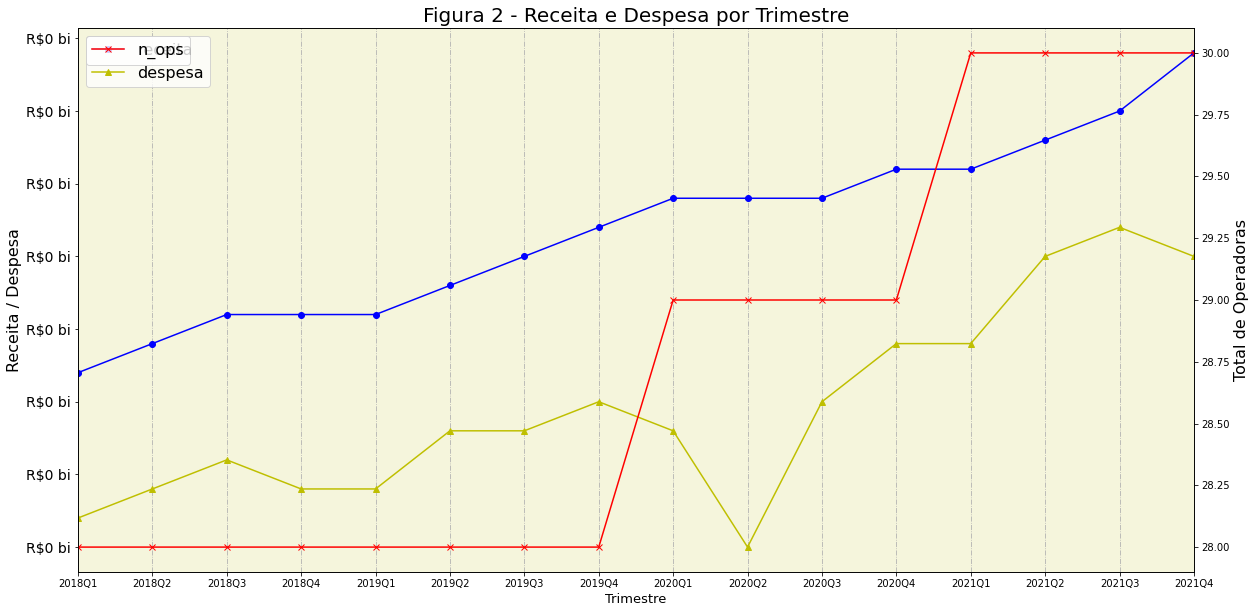

In [34]:
from importlib.metadata import metadata


df_plot = ans_alterada15.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.savefig('emp_filan_01.png',
 bbox_inches="tight",
 pad_inches=1,
 facecolor='w')

plt.show()

del df_plot

In [35]:
#Cria o rankin das operadoras com maior receita e despesa
ans_alterada16 = ans_alterada14.groupby(['ano','cd_ops'], as_index=False).agg({ 'receita':lambda x: sum_million(x),
                                                                                'despesa':lambda x: sum_million(x)})

ans_alterada16.sort_values(by=['ano','receita'], ascending=[True,False], inplace=True)

ans_alterada16.head()

,ano,cd_ops,receita,despesa
15,2018,339954,243.460000,197.370000
1,2018,314218,118.770000,82.020000
16,2018,342556,89.140000,65.950000
23,2018,354562,63.320000,52.450000
3,2018,318299,46.330000,38.990000


In [36]:
ans_alterada_ops = ans_alterada16.head(100)

ans_alterada_ops = ans_alterada_ops[['cd_ops']].reset_index(drop=True)

keys = list(ans_alterada_ops.columns.values)
i1 = ans_alterada14.set_index(keys).index
i2 = ans_alterada_ops.set_index(keys).index

ans_alterada16 =  ans_alterada14[i1.isin(i2)]

ans_alterada16.sort_values(by=['receita'], ascending=False, inplace=True)

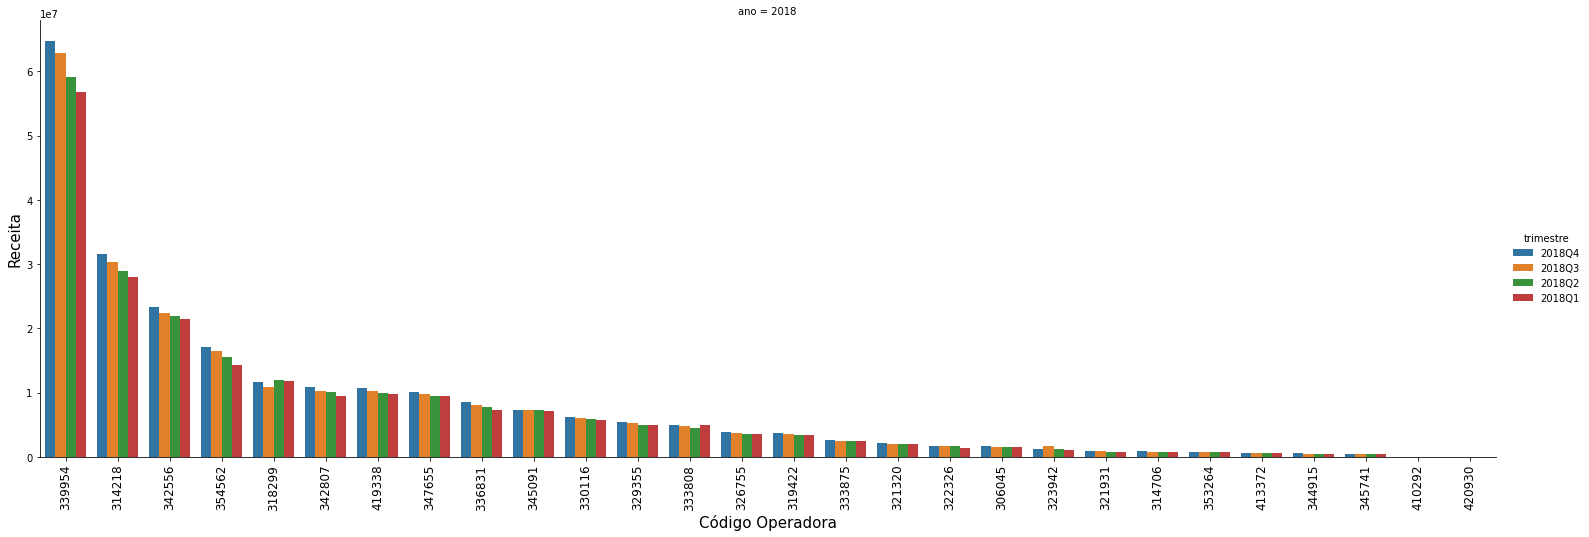

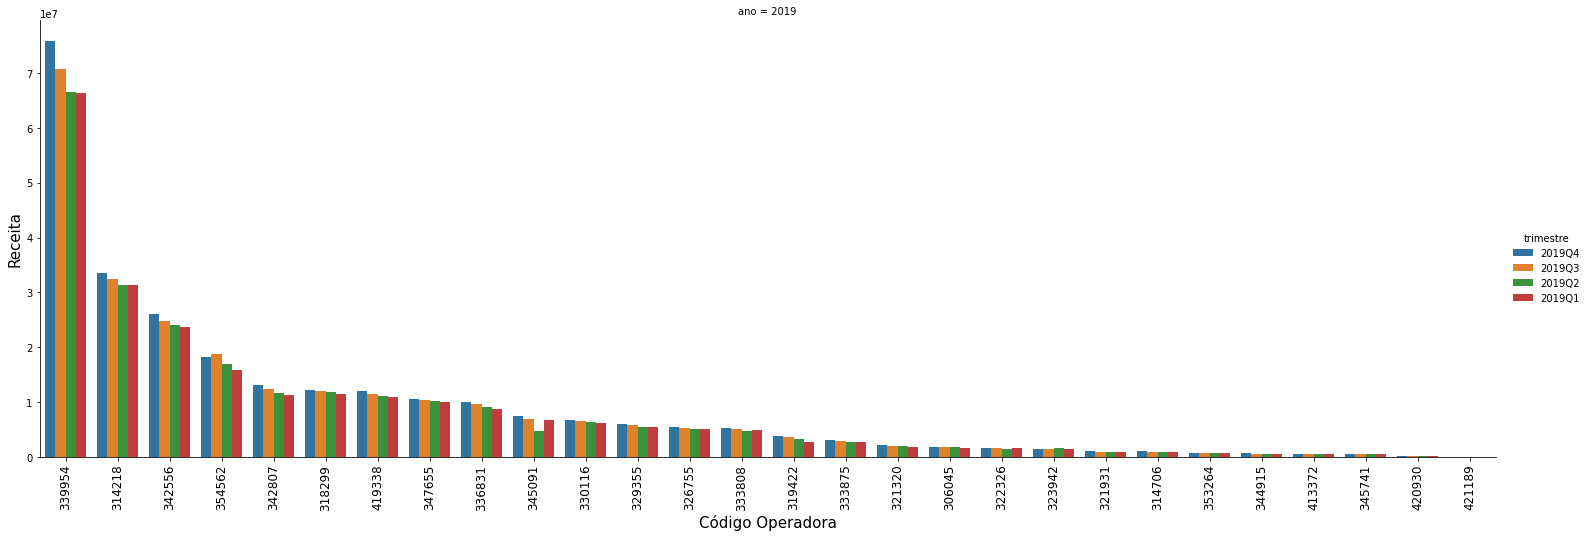

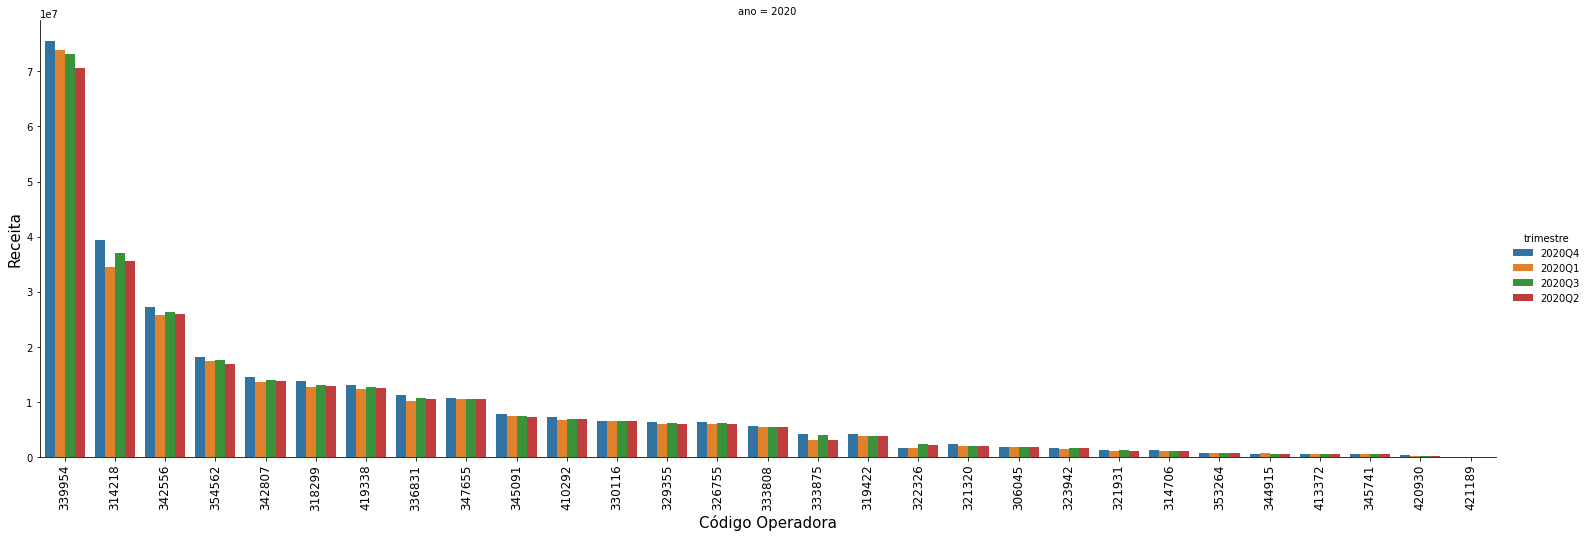

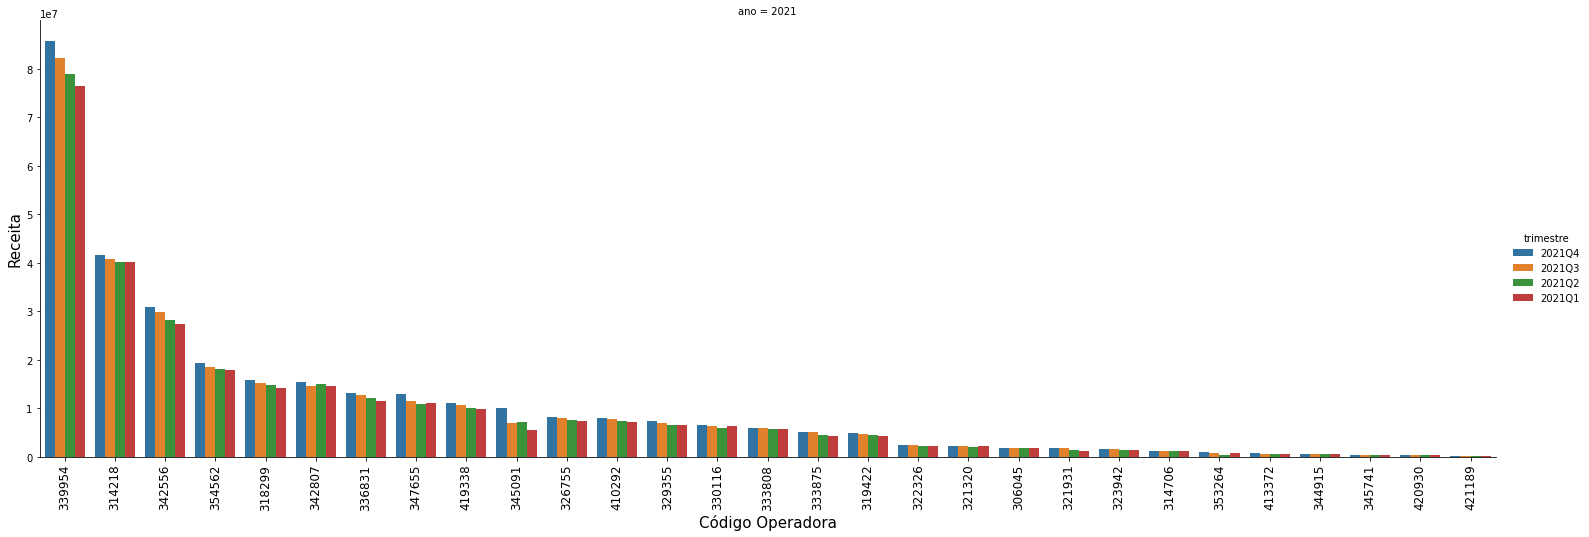

In [37]:
df_plot = ans_alterada16.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

del df_plot

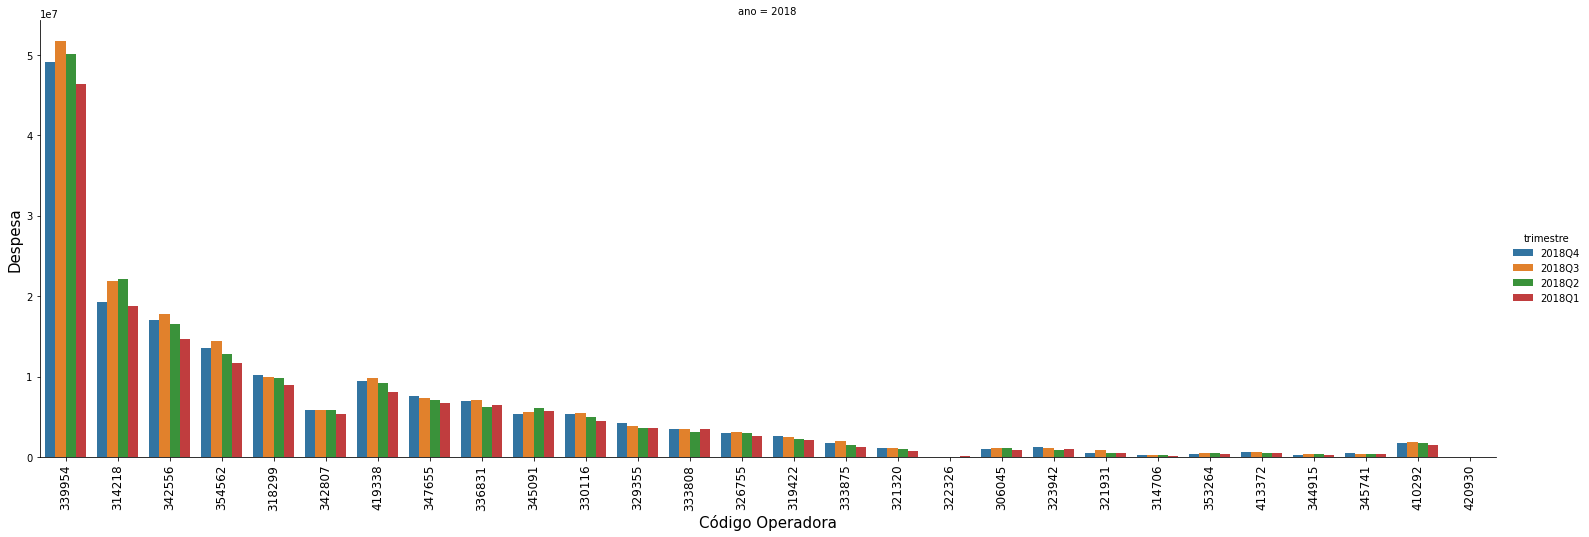

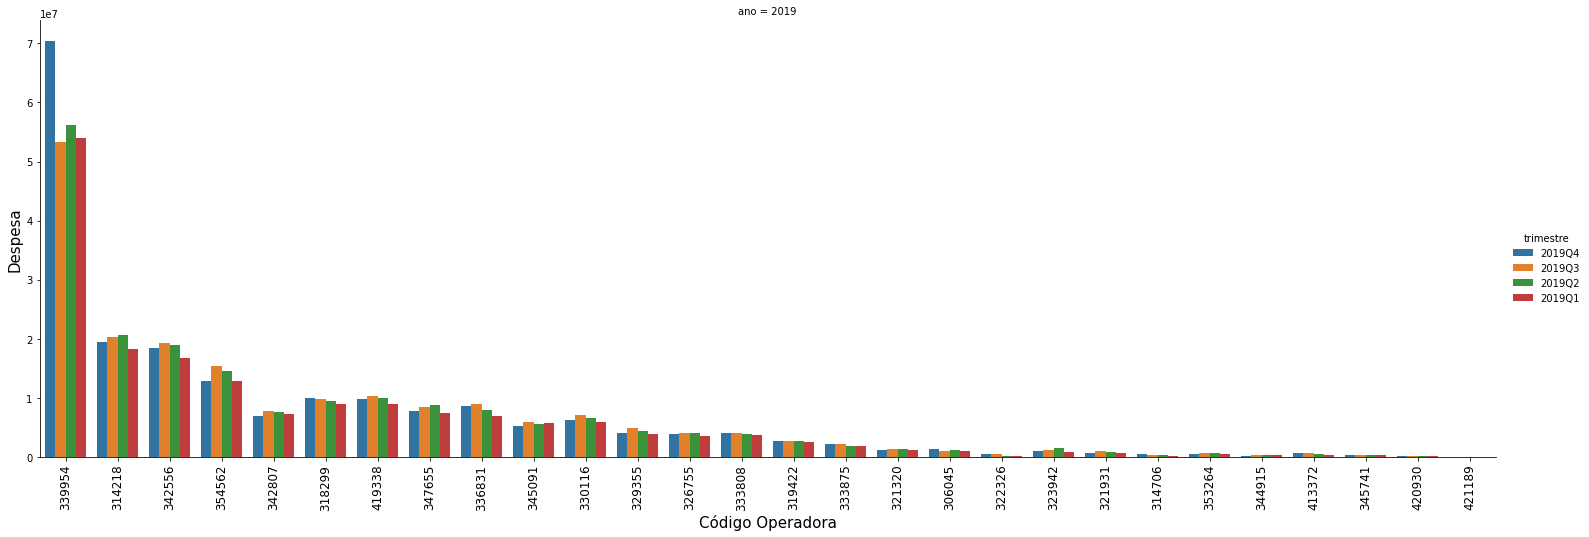

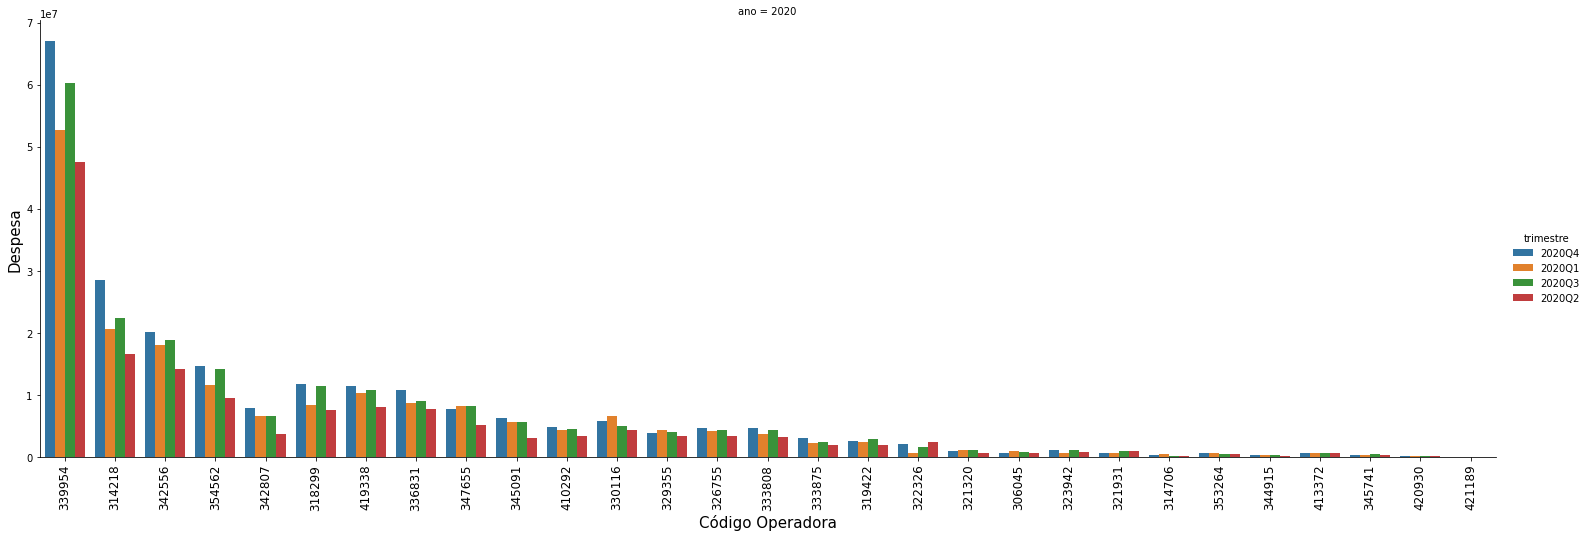

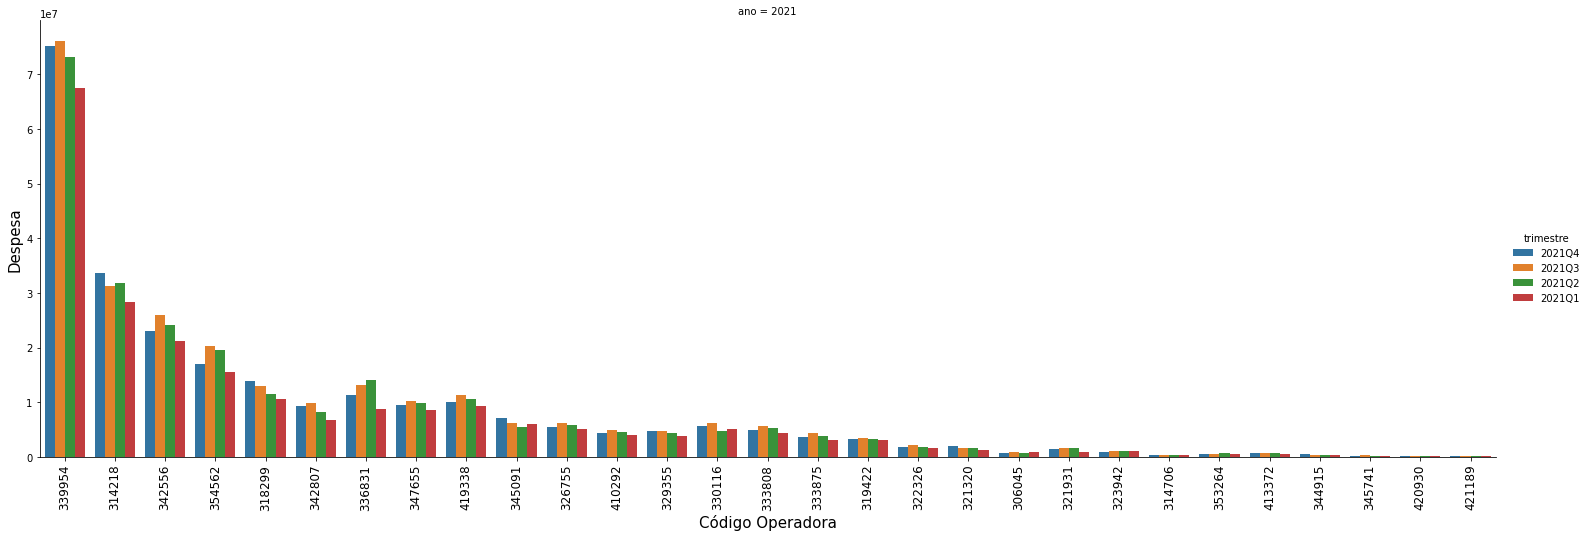

In [38]:
df_plot = ans_alterada16.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

del df_plot